In [27]:
'''
!samtools mpileup CLIP-2J3.bam > CLIP-2J3.pileup
!samtools mpileup CLIP-polyclonal.bam > CLIP-polyclonal.pileup

awk '$4 >= 50' CLIP-2J3.pileup > CLIP-2J3_depth50.pileup
awk '$4 >= 50' CLIP-2J3.pileup > CLIP-polyclonal_depth50.pileup

!gmap_build -D /Users/eunbi/bio1 -d mm39 mm39.fa

# 2J3
cutadapt -a AGATCGGAAGAGC -o SRR458759.cleaned.fastq.gz SRR458759.fastq.gz

!gsnap -D /Users/eunbi/bio1 -d mm39 -A sam --gunzip SRR458759.cleaned.fastq.gz | samtools view -bS - > 2J3.bam

!samtools sort -o CLIP-2J3.bam 2J3.bam
!samtools index CLIP-2J3.bam

#polyclonal
cutadapt -a AGATCGGAAGAGC -o SRR458760.cleaned.fastq.gz SRR458760.fastq.gz

!gsnap -D /Users/eunbi/bio1 -d mm39 -A sam --gunzip SRR458760.cleaned.fastq.gz | samtools view -bS - > polyclonal.bam

!samtools sort -o CLIP-polyclonal.bam polyclonal.bam
!samtools index CLIP-polyclonal.bam
'''

"\n!samtools mpileup CLIP-2J3.bam > CLIP-2J3.pileup\n!samtools mpileup CLIP-polyclonal.bam > CLIP-polyclonal.pileup\n\nawk '$4 >= 50' CLIP-2J3.pileup > CLIP-2J3_depth50.pileup\nawk '$4 >= 50' CLIP-2J3.pileup > CLIP-polyclonal_depth50.pileup\n\n!gmap_build -D /Users/eunbi/bio1 -d mm39 mm39.fa\n\n# 2J3\ncutadapt -a AGATCGGAAGAGC -o SRR458759.cleaned.fastq.gz SRR458759.fastq.gz\n\n!gsnap -D /Users/eunbi/bio1 -d mm39 -A sam --gunzip SRR458759.cleaned.fastq.gz | samtools view -bS - > 2J3.bam\n\n!samtools sort -o CLIP-2J3.bam 2J3.bam\n!samtools index CLIP-2J3.bam\n\n#polyclonal\ncutadapt -a AGATCGGAAGAGC -o SRR458760.cleaned.fastq.gz SRR458760.fastq.gz\n\n!gsnap -D /Users/eunbi/bio1 -d mm39 -A sam --gunzip SRR458760.cleaned.fastq.gz | samtools view -bS - > polyclonal.bam\n\n!samtools sort -o CLIP-polyclonal.bam polyclonal.bam\n!samtools index CLIP-polyclonal.bam\n"

<Figure size 600x400 with 0 Axes>

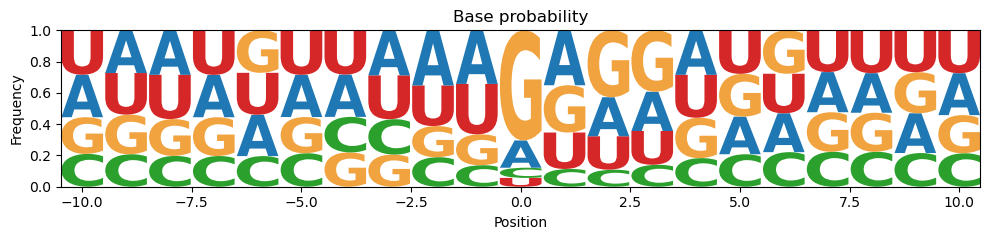

<Figure size 640x480 with 0 Axes>

In [28]:
import pandas as pd
import re
import numpy as np
from pyfaidx import Fasta
from collections import Counter
import logomaker
import matplotlib.pyplot as plt

pileup = pd.read_csv('/Users/eunbi/bio1/CLIP-35L33G_depth50.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])

toremove = re.compile('[<>$*#^]')
pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))


def count_bases(seq: str):
    """Return base counts and total depth for a sequence of A/C/G/T calls."""
    counts = {
        'A': seq.count('A'),
        'C': seq.count('C'),
        'G': seq.count('G'),
        'T': seq.count('T')
    }
    total = sum(counts.values())
    return counts, total

# 2. 각 position별로 Shannon entropy를 계산
def shannon_entropy(counts: dict, total: int) -> float:
    if total == 0:
        return 0.0
    probs = np.array(list(counts.values()), dtype=float) / total
    probs = probs[probs > 0]  # avoid log2(0)
    return float(-np.sum(probs * np.log2(probs)))

# 3. 계산한 Shannon entropy를 bedgraph format으로 출력
records = []
for chrom, pos, matches in pileup[['chrom', 'pos', 'matches']].itertuples(index=False):
    counts, depth = count_bases(matches)
    entropy = shannon_entropy(counts, depth)
    start = int(pos) - 1   # bedgraph: 0‑based, half‑open interval
    end   = int(pos)       # end is 1‑based exclusive
    records.append((chrom, start, end, entropy))

entropy_df = pd.DataFrame(records, columns=['chrom', 'start', 'end', 'entropy'])

high_entropy_df = entropy_df[entropy_df["entropy"] >= 0.8]

# Reference genome에서 ±10bp 서열 추출
ref = Fasta("/Users/eunbi/bio1/mm39.fa")  # 경로에 맞게 수정
motifs = []

for _, row in high_entropy_df.iterrows():
    chrom = row["chrom"]
    pos = int(row["start"])  # 중심 위치
    try:
        seq = ref[chrom][pos - 10:pos + 11].seq.upper()
        seq = seq.replace("T", "U")
        if len(seq) == 21:
            motifs.append(seq)
    except:
        continue

df_fasta = pd.DataFrame({"seq": motifs})

seqs = df_fasta["seq"].tolist()
counts = [Counter(col) for col in zip(*seqs)]
df_freq = pd.DataFrame(counts).fillna(0)[["A", "C", "G", "U"]]
df_freq.index = range(-10, 11)

# Base probability
df_freq_norm = df_freq.div(df_freq.sum(axis=1), axis=0)
plt.figure(figsize=(6, 4))

custom_colors = {'A': '#1f77b4',  # blue
                 'C': '#2ca02c',  # green
                 'G': '#f1a340',  # yellow
                 'U': '#d62728'}  # red

logomaker.Logo(df_freq_norm, color_scheme=custom_colors)

plt.title("Base probability")
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.savefig("/Users/eunbi/bio1/35L33G_base.png", dpi=300)

<Figure size 600x400 with 0 Axes>

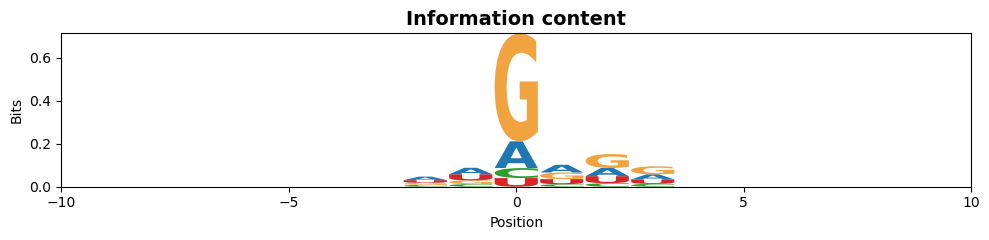

<Figure size 640x480 with 0 Axes>

In [29]:
# Information content
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import logomaker

# seqs: 전체 motif 리스트 (21nt)
seqs = [s.replace("T", "U") for s in df_fasta["seq"]]  # RNA > DNA

# -2 ~ +3 위치만 잘라내기
hexamers = [s[8:14] for s in seqs if len(s) == 21]  # 중심이 인덱스 10 → -2 = 8, +3 = 13

# 빈도 행렬 만들기
counts = [Counter(col) for col in zip(*hexamers)]
df_freq = pd.DataFrame(counts).fillna(0)[["A", "C", "G", "U"]]
df_freq.index = range(-2, 4)

# 정보량 계산
df_bits = logomaker.transform_matrix(df_freq, from_type='counts', to_type='information')

# 그래프
plt.figure(figsize=(6, 4))
custom_colors = {'A': '#1f77b4',  # blue
                 'C': '#2ca02c',  # green
                 'G': '#f1a340',  # yellow
                 'U': '#d62728'}  # red
logomaker.Logo(df_bits, color_scheme=custom_colors)
plt.title("Information content", fontsize=14, weight='bold')
plt.xlabel("Position")
plt.ylabel("Bits")
plt.xticks(range(-10, 11, 5))
plt.xlim(-10, 10)
plt.tight_layout()
plt.show()
plt.savefig("/Users/eunbi/bio1/35L33G_info.png", dpi=300)

<Figure size 600x400 with 0 Axes>

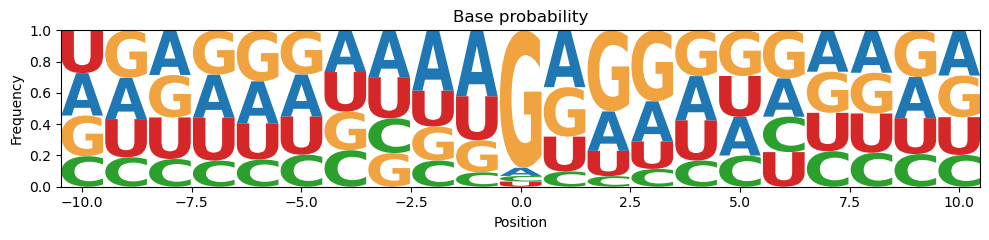

<Figure size 640x480 with 0 Axes>

In [30]:
import pandas as pd
import re
import numpy as np
from pyfaidx import Fasta
from collections import Counter
import logomaker
import matplotlib.pyplot as plt

pileup = pd.read_csv('/Users/eunbi/bio1/CLIP-2J3_depth50.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])

toremove = re.compile('[<>$*#^]')
pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))


def count_bases(seq: str):
    """Return base counts and total depth for a sequence of A/C/G/T calls."""
    counts = {
        'A': seq.count('A'),
        'C': seq.count('C'),
        'G': seq.count('G'),
        'T': seq.count('T')
    }
    total = sum(counts.values())
    return counts, total

# 2. 각 position별로 Shannon entropy를 계산
def shannon_entropy(counts: dict, total: int) -> float:
    if total == 0:
        return 0.0
    probs = np.array(list(counts.values()), dtype=float) / total
    probs = probs[probs > 0]  # avoid log2(0)
    return float(-np.sum(probs * np.log2(probs)))

# 3. 계산한 Shannon entropy를 bedgraph format으로 출력
records = []
for chrom, pos, matches in pileup[['chrom', 'pos', 'matches']].itertuples(index=False):
    counts, depth = count_bases(matches)
    entropy = shannon_entropy(counts, depth)
    start = int(pos) - 1   # bedgraph: 0‑based, half‑open interval
    end   = int(pos)       # end is 1‑based exclusive
    records.append((chrom, start, end, entropy))

entropy_df = pd.DataFrame(records, columns=['chrom', 'start', 'end', 'entropy'])

high_entropy_df = entropy_df[entropy_df["entropy"] >= 0.8]

# Reference genome에서 ±10bp 서열 추출
ref = Fasta("/Users/eunbi/bio1/mm39.fa")  # 경로에 맞게 수정
motifs = []

for _, row in high_entropy_df.iterrows():
    chrom = row["chrom"]
    pos = int(row["start"])  # 중심 위치
    try:
        seq = ref[chrom][pos - 10:pos + 11].seq.upper()
        seq = seq.replace("T", "U")
        if len(seq) == 21:
            motifs.append(seq)
    except:
        continue

df_fasta = pd.DataFrame({"seq": motifs})

seqs = df_fasta["seq"].tolist()
counts = [Counter(col) for col in zip(*seqs)]
df_freq = pd.DataFrame(counts).fillna(0)[["A", "C", "G", "U"]]
df_freq.index = range(-10, 11)

# Base probability
df_freq_norm = df_freq.div(df_freq.sum(axis=1), axis=0)
plt.figure(figsize=(6, 4))

custom_colors = {'A': '#1f77b4',  # blue
                 'C': '#2ca02c',  # green
                 'G': '#f1a340',  # orange
                 'U': '#d62728'}  # red

logomaker.Logo(df_freq_norm, color_scheme=custom_colors)

plt.title("Base probability")
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.savefig("/Users/eunbi/bio1/2J3_base.png", dpi=300)

<Figure size 600x400 with 0 Axes>

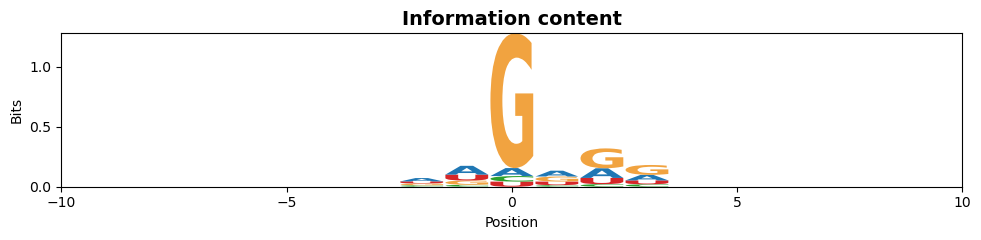

<Figure size 640x480 with 0 Axes>

In [31]:
# Information content
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import logomaker

# seqs: 전체 motif 리스트 (21nt)
seqs = [s.replace("T", "U") for s in df_fasta["seq"]]  # RNA > DNA

# -2 ~ +3 위치만 잘라내기
hexamers = [s[8:14] for s in seqs if len(s) == 21]  # 중심이 인덱스 10 → -2 = 8, +3 = 13

# 빈도 행렬 만들기
counts = [Counter(col) for col in zip(*hexamers)]
df_freq = pd.DataFrame(counts).fillna(0)[["A", "C", "G", "U"]]
df_freq.index = range(-2, 4)

# 정보량 계산
df_bits = logomaker.transform_matrix(df_freq, from_type='counts', to_type='information')

# 그래프
plt.figure(figsize=(6, 4))
custom_colors = {'A': '#1f77b4',  # blue
                 'C': '#2ca02c',  # green
                 'G': '#f1a340',  # yellow
                 'U': '#d62728'}  # red
logomaker.Logo(df_bits, color_scheme=custom_colors)
plt.title("Information content", fontsize=14, weight='bold')
plt.xlabel("Position")
plt.ylabel("Bits")
plt.xticks(range(-10, 11, 5))
plt.xlim(-10, 10)
plt.tight_layout()
plt.show()
plt.savefig("/Users/eunbi/bio1/2J3_info.png", dpi=300)

<Figure size 600x400 with 0 Axes>

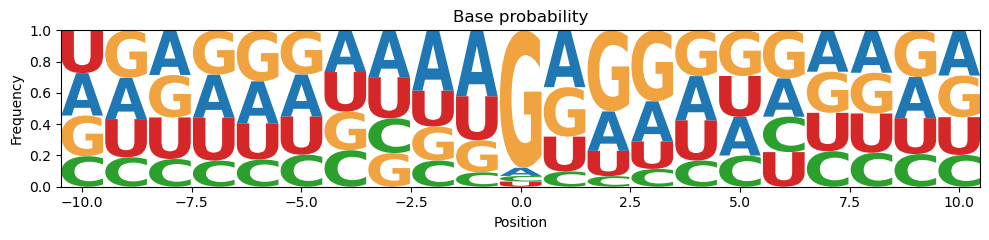

<Figure size 640x480 with 0 Axes>

In [32]:
import pandas as pd
import re
import numpy as np
from pyfaidx import Fasta
from collections import Counter
import logomaker
import matplotlib.pyplot as plt

pileup = pd.read_csv('/Users/eunbi/bio1/CLIP-polyclonal_depth50.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])

toremove = re.compile('[<>$*#^]')
pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))


def count_bases(seq: str):
    """Return base counts and total depth for a sequence of A/C/G/T calls."""
    counts = {
        'A': seq.count('A'),
        'C': seq.count('C'),
        'G': seq.count('G'),
        'T': seq.count('T')
    }
    total = sum(counts.values())
    return counts, total

# 2. 각 position별로 Shannon entropy를 계산
def shannon_entropy(counts: dict, total: int) -> float:
    if total == 0:
        return 0.0
    probs = np.array(list(counts.values()), dtype=float) / total
    probs = probs[probs > 0]  # avoid log2(0)
    return float(-np.sum(probs * np.log2(probs)))

# 3. 계산한 Shannon entropy를 bedgraph format으로 출력
records = []
for chrom, pos, matches in pileup[['chrom', 'pos', 'matches']].itertuples(index=False):
    counts, depth = count_bases(matches)
    entropy = shannon_entropy(counts, depth)
    start = int(pos) - 1   # bedgraph: 0‑based, half‑open interval
    end   = int(pos)       # end is 1‑based exclusive
    records.append((chrom, start, end, entropy))

entropy_df = pd.DataFrame(records, columns=['chrom', 'start', 'end', 'entropy'])

high_entropy_df = entropy_df[entropy_df["entropy"] >= 0.8]

# Reference genome에서 ±10bp 서열 추출
ref = Fasta("/Users/eunbi/bio1/mm39.fa")  # 경로에 맞게 수정
motifs = []

for _, row in high_entropy_df.iterrows():
    chrom = row["chrom"]
    pos = int(row["start"])  # 중심 위치
    try:
        seq = ref[chrom][pos - 10:pos + 11].seq.upper()
        seq = seq.replace("T", "U")
        if len(seq) == 21:
            motifs.append(seq)
    except:
        continue

df_fasta = pd.DataFrame({"seq": motifs})

seqs = df_fasta["seq"].tolist()
counts = [Counter(col) for col in zip(*seqs)]
df_freq = pd.DataFrame(counts).fillna(0)[["A", "C", "G", "U"]]
df_freq.index = range(-10, 11)

# Base probability
df_freq_norm = df_freq.div(df_freq.sum(axis=1), axis=0)
plt.figure(figsize=(6, 4))

custom_colors = {'A': '#1f77b4',  # blue
                 'C': '#2ca02c',  # green
                 'G': '#f1a340',  # orange
                 'U': '#d62728'}  # red

logomaker.Logo(df_freq_norm, color_scheme=custom_colors)

plt.title("Base probability")
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.savefig("/Users/eunbi/bio1/polyclonal_base.png", dpi=300)

<Figure size 600x400 with 0 Axes>

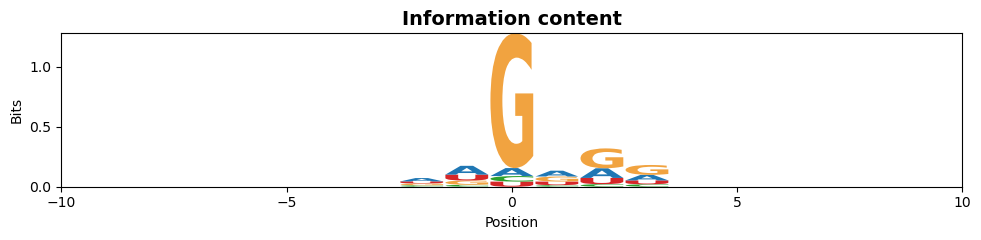

<Figure size 640x480 with 0 Axes>

In [33]:
# Information content
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import logomaker

# seqs: 전체 motif 리스트 (21nt)
seqs = [s.replace("T", "U") for s in df_fasta["seq"]]  # RNA > DNA

# -2 ~ +3 위치만 잘라내기
hexamers = [s[8:14] for s in seqs if len(s) == 21]  # 중심이 인덱스 10 → -2 = 8, +3 = 13

# 빈도 행렬 만들기
counts = [Counter(col) for col in zip(*hexamers)]
df_freq = pd.DataFrame(counts).fillna(0)[["A", "C", "G", "U"]]
df_freq.index = range(-2, 4)

# 정보량 계산
df_bits = logomaker.transform_matrix(df_freq, from_type='counts', to_type='information')

# 그래프
plt.figure(figsize=(6, 4))
custom_colors = {'A': '#1f77b4',  # blue
                 'C': '#2ca02c',  # green
                 'G': '#f1a340',  # yellow
                 'U': '#d62728'}  # red
logomaker.Logo(df_bits, color_scheme=custom_colors)
plt.title("Information content", fontsize=14, weight='bold')
plt.xlabel("Position")
plt.ylabel("Bits")
plt.xticks(range(-10, 11, 5))
plt.xlim(-10, 10)
plt.tight_layout()
plt.show()
plt.savefig("/Users/eunbi/bio1/polyclonal_info.png", dpi=300)